## Problem Statement
#### In this assignment students need to predict whether a person makes over 50K per year or not from classic adult dataset using XGBoost.

##### The description of the dataset is as follows:
- Data Set Information: Extraction was done by Barry Becker from the 1994 Census database. A set of reasonably clean records was extracted using the following conditions:

((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))
Attribute Information: Listing of attributes:

50K, <=50K.

- age: continuous.
- workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov,Without-pay, Never-worked.
- fnlwgt: continuous.
- education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. education-num: continuous.
- marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
- occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof- specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing,
- Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
- relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
- race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
- sex: Female, Male.
- capital-gain: continuous.
- capital-loss: continuous.
- hours-per-week: continuous.
- native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands

In [1]:
## importing librarry
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn import datasets, model_selection, tree, preprocessing, metrics, linear_model
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeClassifier
import warnings; warnings.simplefilter('ignore')

In [2]:
## importing testing and training dataet
train_set = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header = None)
test_set = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test', skiprows = 1, header = None)

In [3]:
print ("Train Size : ",train_set.shape)
print ("Test Size : ", test_set.shape)

Train Size :  (32561, 15)
Test Size :  (16281, 15)


### Data Preprocessing

##### Merging train and test Split for applying cross validation

In [4]:
X=test_set.append(train_set)
X.shape

(48842, 15)

In [5]:
## Adding feature names to the dataset
col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status',
'occupation','relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week',
'native_country', 'wage_class']
X.columns = col_labels

In [6]:
X.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


##### Data Visualization

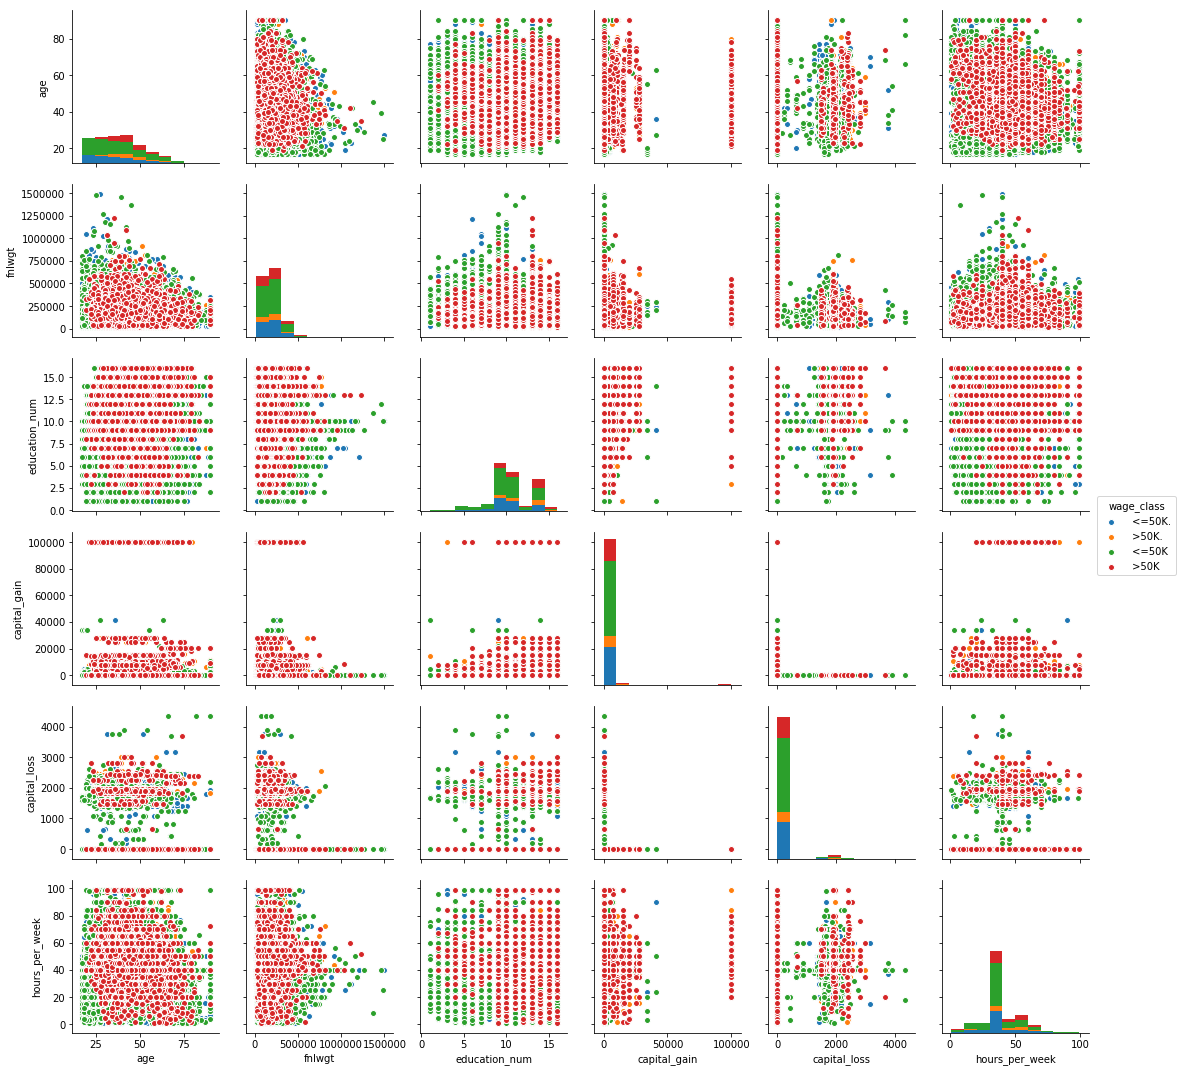

In [7]:
sb.pairplot(X,hue='wage_class')

* If we see the denpendent variables they are not uniform after the merging of test and train set. Applying data preprocessing steps

In [8]:
X.wage_class.value_counts()

 <=50K     24720
 <=50K.    12435
 >50K       7841
 >50K.      3846
Name: wage_class, dtype: int64

In [9]:
X.wage_class=X.wage_class.map({' <=50K': '<=50K', ' <=50K.': '<=50K', ' >50K': '>50K', ' >50K.': '>50K'})

In [10]:
X.wage_class.value_counts()

<=50K    37155
>50K     11687
Name: wage_class, dtype: int64

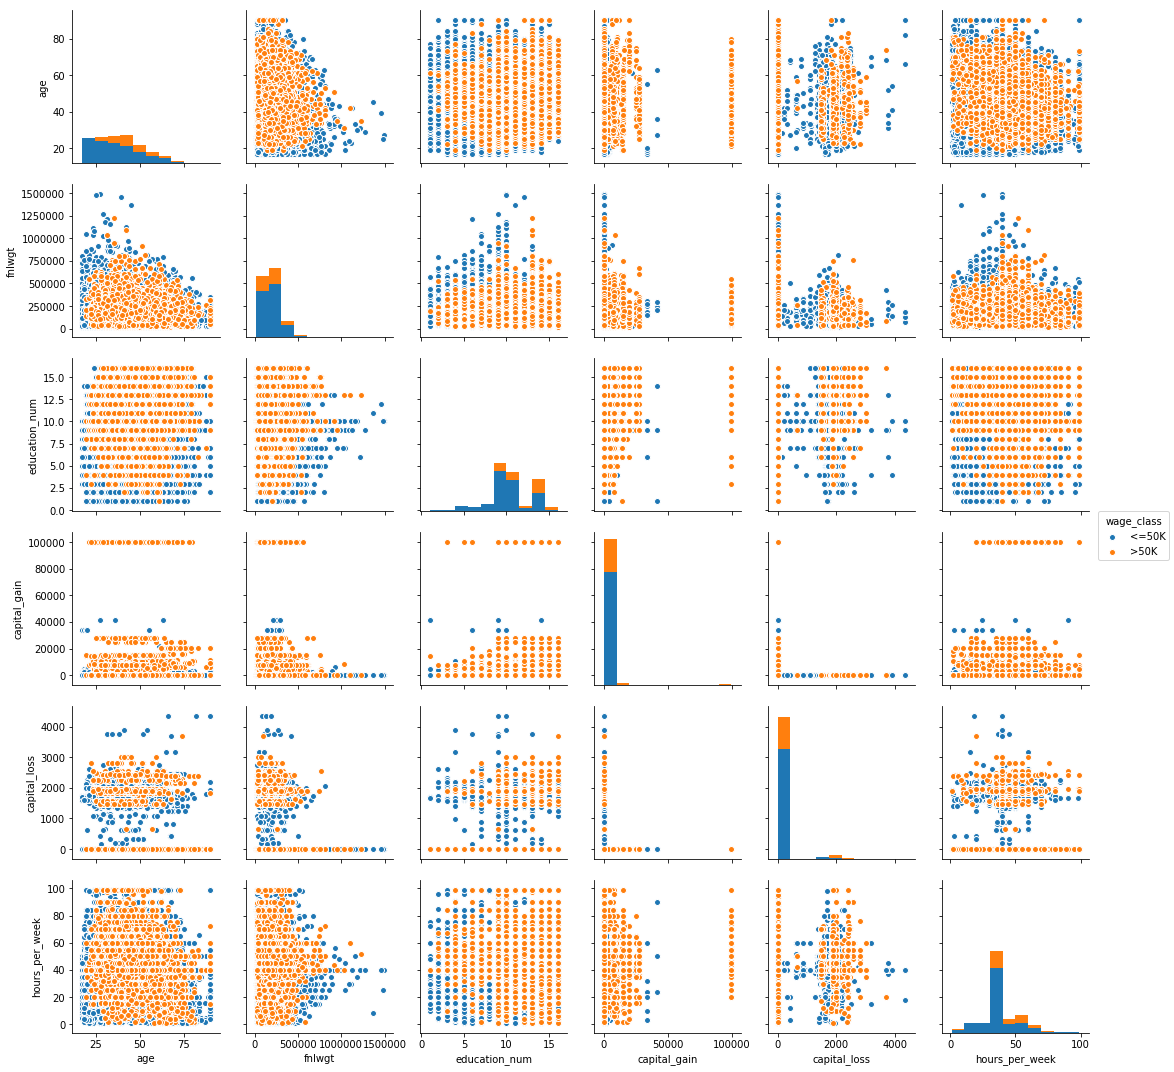

In [11]:
## Plotting the graph after making the dependent variables uniform
sb.pairplot(X,hue='wage_class')

#### Checking for null values

In [12]:
X.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
wage_class        0
dtype: int64

* There are no null values in the dataset

#### Find categorical variables in the dataset

In [13]:
list(X.dtypes[X.dtypes == "object"].index)

['workclass',
 'education',
 'marital_status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native_country',
 'wage_class']

#### Find Unique Variable count

In [14]:
X.workclass.value_counts()

 Private             33906
 Self-emp-not-inc     3862
 Local-gov            3136
 ?                    2799
 State-gov            1981
 Self-emp-inc         1695
 Federal-gov          1432
 Without-pay            21
 Never-worked           10
Name: workclass, dtype: int64

In [15]:
X.education.value_counts()

 HS-grad         15784
 Some-college    10878
 Bachelors        8025
 Masters          2657
 Assoc-voc        2061
 11th             1812
 Assoc-acdm       1601
 10th             1389
 7th-8th           955
 Prof-school       834
 9th               756
 12th              657
 Doctorate         594
 5th-6th           509
 1st-4th           247
 Preschool          83
Name: education, dtype: int64

In [16]:
X.marital_status.value_counts()

 Married-civ-spouse       22379
 Never-married            16117
 Divorced                  6633
 Separated                 1530
 Widowed                   1518
 Married-spouse-absent      628
 Married-AF-spouse           37
Name: marital_status, dtype: int64

In [17]:
X.occupation.value_counts()

 Prof-specialty       6172
 Craft-repair         6112
 Exec-managerial      6086
 Adm-clerical         5611
 Sales                5504
 Other-service        4923
 Machine-op-inspct    3022
 ?                    2809
 Transport-moving     2355
 Handlers-cleaners    2072
 Farming-fishing      1490
 Tech-support         1446
 Protective-serv       983
 Priv-house-serv       242
 Armed-Forces           15
Name: occupation, dtype: int64

In [18]:
X.relationship.value_counts()

 Husband           19716
 Not-in-family     12583
 Own-child          7581
 Unmarried          5125
 Wife               2331
 Other-relative     1506
Name: relationship, dtype: int64

In [19]:
X.race.value_counts()

 White                 41762
 Black                  4685
 Asian-Pac-Islander     1519
 Amer-Indian-Eskimo      470
 Other                   406
Name: race, dtype: int64

In [20]:
X.sex.value_counts()

 Male      32650
 Female    16192
Name: sex, dtype: int64

In [21]:
X.native_country.unique().shape

(42,)

In [22]:
X.wage_class.value_counts()

<=50K    37155
>50K     11687
Name: wage_class, dtype: int64

In [23]:
## Reading the categorical varibales in dataset
categorical_variables = list(X.dtypes[X.dtypes == "object"].index)

### Replacing categorical variables with numbers
for variables in categorical_variables:
    ##Replacing with dummy variables
    dummies = pd.get_dummies(X[variables],prefix=variables)
    X=pd.concat([X,dummies.iloc[:,1:]],axis=1)
    X.drop([variables],inplace=True,axis=1)


In [24]:
X.shape

(48842, 101)

In [25]:
X.columns

Index(['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss',
       'hours_per_week', 'workclass_ Federal-gov', 'workclass_ Local-gov',
       'workclass_ Never-worked', 'workclass_ Private',
       ...
       'native_country_ Puerto-Rico', 'native_country_ Scotland',
       'native_country_ South', 'native_country_ Taiwan',
       'native_country_ Thailand', 'native_country_ Trinadad&Tobago',
       'native_country_ United-States', 'native_country_ Vietnam',
       'native_country_ Yugoslavia', 'wage_class_>50K'],
      dtype='object', length=101)

0    37155
1    11687
Name: wage_class_>50K, dtype: int64


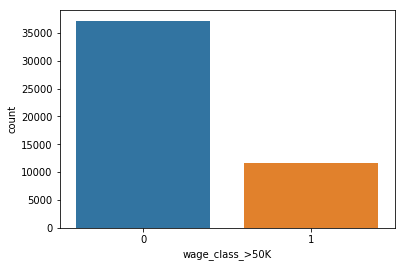

In [26]:
print(X['wage_class_>50K'].value_counts())
sb.countplot(x='wage_class_>50K',data=X)
plt.show()

In [27]:
count_income_morethan_50 = len(X[X['wage_class_>50K']==1])
count_income_lessthan_50 = len(X[X['wage_class_>50K']==0])
pct_income_morethan_50 = count_income_morethan_50/(count_income_morethan_50+count_income_lessthan_50)
print("percentage of income morethan 50:", pct_income_morethan_50*100)
pct_income_lessthan_50 = count_income_lessthan_50/(count_income_morethan_50+count_income_lessthan_50)
print("percentage of income lessthan 50:", pct_income_lessthan_50*100)

percentage of income morethan 50: 23.928176569346054
percentage of income lessthan 50: 76.07182343065395


###### Our dataset is an imbalanced dataset. Applying Up_sampling of minority class to make it balance
* Up-sampling is the process of randomly duplicating observations from the minority class in order to reinforce its signal.

In [28]:
from sklearn.utils import resample

# Separate majority and minority classes
X_majority = X[X['wage_class_>50K']==0]
X_minority = X[X['wage_class_>50K']==1]

# Upsample minority class
X_minority_upsampled = resample(X_minority, replace=True, n_samples=37155, random_state=0) 

# Combine majority class with upsampled minority class
X1 = pd.concat([X_majority, X_minority_upsampled])

X1['wage_class_>50K'].value_counts()

1    37155
0    37155
Name: wage_class_>50K, dtype: int64

1    37155
0    37155
Name: wage_class_>50K, dtype: int64


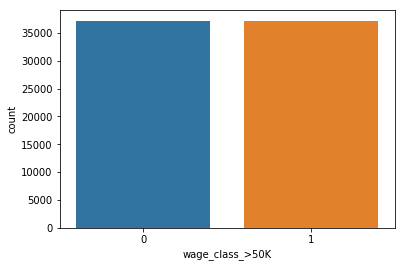

In [29]:
print(X1['wage_class_>50K'].value_counts())
sb.countplot(x='wage_class_>50K',data=X1)
plt.show()

In [30]:
count_income_morethan_50 = len(X1[X1['wage_class_>50K']==1])
count_income_lessthan_50 = len(X1[X1['wage_class_>50K']==0])
pct_income_morethan_50 = count_income_morethan_50/(count_income_morethan_50+count_income_lessthan_50)
print("percentage of income morethan 50:", pct_income_morethan_50*100)
pct_income_lessthan_50 = count_income_lessthan_50/(count_income_morethan_50+count_income_lessthan_50)
print("percentage of income lessthan 50:", pct_income_lessthan_50*100)

percentage of income morethan 50: 50.0
percentage of income lessthan 50: 50.0


##### Splitting dependent and depndent variables

In [31]:
Y=X1.iloc[:,-1].values
X2=X1.drop('wage_class_>50K',axis=1).values
X2.shape

(74310, 100)

In [32]:
Y.shape

(74310,)

##### Train, test Split

In [33]:
from sklearn.model_selection import train_test_split
# Splitting the model in to train and test
X_train,X_test,y_train,y_test=train_test_split(X2,Y,test_size=.2,random_state=0)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((59448, 100), (14862, 100), (59448,), (14862,))

In [34]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### 1.  Logistic Regression

In [35]:
## Importing Logistic Regression
from sklearn.linear_model import LogisticRegression

In [36]:
lr_model = LogisticRegression(random_state=0)
lr_model.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [37]:
y_pred=lr_model.predict(X_test)
# Is our model still predicting just one class?

print(metrics.accuracy_score(y_test,y_pred))

0.820683622661822


##### Plotting Confusion Matrx

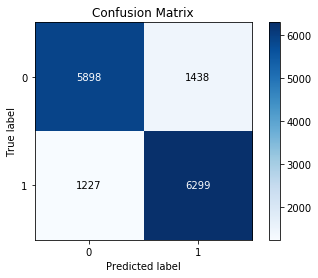

In [38]:
import scikitplot
scikitplot.metrics.plot_confusion_matrix(y_test,y_pred)

#####  Applying 10 Fold Cross Validation

In [39]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator= LogisticRegression(),     # Model to test
                X= X2,  
                y = Y,      # Target variable
                scoring = "accuracy",               # Scoring metric    
                cv=10)                              # Cross validation folds

print("Accuracy per fold: ")
print("Cross Validation score: ", scores)
print("Average accuracy: ", scores.mean())

Accuracy per fold: 
Cross Validation score:  [0.81270183 0.81754575 0.78323466 0.80274489 0.79480624 0.7960969
 0.81009421 0.79138627 0.82193809 0.80753701]
Average accuracy:  0.8038085859119996


##### Important Feature Selection

* Recursive Feature Elimination (RFE) is based on the idea to repeatedly construct a model and choose either the best or worst performing feature, setting the feature aside and then repeating the process with the rest of the features. This process is applied until all features in the dataset are exhausted. The goal of RFE is to select features by recursively considering smaller and smaller sets of features.

In [40]:
from sklearn.feature_selection import RFE
selector =  RFE(estimator=LogisticRegression(), step=1)
selector.fit(X2,Y)

RFE(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
  n_features_to_select=None, step=1, verbose=0)

* Selecting only the features with Rank 1

##### Important Features of Dataset

In [41]:
ranks = selector.ranking_.tolist()
df_rank = pd.DataFrame({'Feature':X.drop('wage_class_>50K', axis=1).columns,'Rank':ranks})
print(df_rank.Feature[df_rank.Rank==1].values)

['workclass_ Federal-gov' 'workclass_ Never-worked'
 'workclass_ Self-emp-inc' 'education_ Assoc-acdm' 'education_ Assoc-voc'
 'education_ Bachelors' 'education_ Doctorate' 'education_ HS-grad'
 'education_ Masters' 'education_ Prof-school' 'education_ Some-college'
 'marital_status_ Married-AF-spouse' 'marital_status_ Married-civ-spouse'
 'marital_status_ Never-married' 'occupation_ Exec-managerial'
 'occupation_ Farming-fishing' 'occupation_ Handlers-cleaners'
 'occupation_ Other-service' 'occupation_ Priv-house-serv'
 'occupation_ Prof-specialty' 'occupation_ Protective-serv'
 'occupation_ Sales' 'occupation_ Tech-support'
 'relationship_ Other-relative' 'relationship_ Own-child'
 'relationship_ Wife' 'sex_ Male' 'native_country_ Cambodia'
 'native_country_ China' 'native_country_ Columbia'
 'native_country_ Dominican-Republic' 'native_country_ Ecuador'
 'native_country_ El-Salvador' 'native_country_ England'
 'native_country_ Guatemala' 'native_country_ Hong'
 'native_country_ Irel

###### Creating model with important Features

In [42]:
X3=X1[df_rank.Feature[df_rank.Rank==1].values]

In [43]:
# Splitting the model in to train and test
X_train,X_test,y_train,y_test=train_test_split(X3,Y,test_size=.2,random_state=0)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((59448, 50), (14862, 50), (59448,), (14862,))

In [44]:
lr_model_rank1 = LogisticRegression(random_state=0)
lr_model_rank1.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [45]:
y_pred_r1=lr_model_rank1.predict(X_test)

print(metrics.accuracy_score(y_test,y_pred_r1))

0.7974700578656978


#### Plotting Confusion Matrx

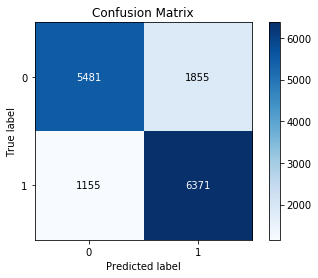

In [46]:
scikitplot.metrics.plot_confusion_matrix(y_test,y_pred_r1)

##### Applying 10 Fold Cross Validation

In [47]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator= LogisticRegression(),     # Model to test
                X= X3,  
                y = Y,      # Target variable
                scoring = "accuracy",               # Scoring metric    
                cv=10)                              # Cross validation folds

print("Accuracy per fold: ")
print("Cross Validation score: ", scores)
print("Average accuracy: ", scores.mean())

Accuracy per fold: 
Cross Validation score:  [0.80664693 0.80368676 0.79668999 0.79709365 0.79978471 0.80148048
 0.79703903 0.79892328 0.80484522 0.7960969 ]
Average accuracy:  0.8002286971185677


##### Compute precision, recall, F-measure and support

* The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier to not label a sample as positive if it is negative.

* The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

* The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.

* The F-beta score weights the recall more than the precision by a factor of beta. beta = 1.0 means recall and precision are equally important.

In [48]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_r1))

             precision    recall  f1-score   support

          0       0.83      0.75      0.78      7336
          1       0.77      0.85      0.81      7526

avg / total       0.80      0.80      0.80     14862



#### ROC Curve
* The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).

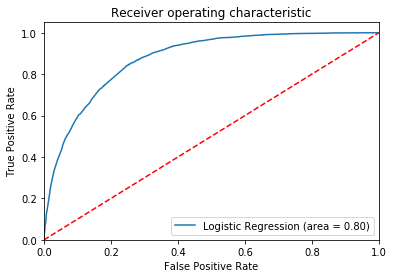

In [49]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, lr_model_rank1.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, lr_model_rank1.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

### 2. Decision Tree Classifier

In [50]:
# Splitting the model in to train and test
X_train,X_test,y_train,y_test=train_test_split(X2,Y,test_size=.2,random_state=0)
#build the model
dtree_model = DecisionTreeClassifier(random_state=0,criterion = 'entropy')
#train the model
dtree_model.fit(X_train,y_train)
#Model parameters study
y_pred = dtree_model.predict(X_test)
# generate evaluation metrics
print("accuracy of Decision Tree Classifier :",metrics.accuracy_score(y_test, y_pred))

accuracy of Decision Tree Classifier : 0.9197281657919526


##### Optimizing Max Dept

In [51]:
for depth in range(15):
    #build the model
    depth = depth + 1
    dtree_model = DecisionTreeClassifier(max_depth=depth,random_state=0,criterion = 'entropy')
    #train the model
    dtree_model.fit(X_train,y_train)
    #Model parameters study
    y_pred = dtree_model.predict(X_test)
    # generate evaluation metrics
    print("accuracy of Decision Tree Classifier for max_depth ", depth," : ",metrics.accuracy_score(y_test, y_pred))

accuracy of Decision Tree Classifier for max_depth  1  :  0.7630197819943481
accuracy of Decision Tree Classifier for max_depth  2  :  0.7807832054905127
accuracy of Decision Tree Classifier for max_depth  3  :  0.7807832054905127
accuracy of Decision Tree Classifier for max_depth  4  :  0.7991522002422285
accuracy of Decision Tree Classifier for max_depth  5  :  0.8128784820347195
accuracy of Decision Tree Classifier for max_depth  6  :  0.813349481900148
accuracy of Decision Tree Classifier for max_depth  7  :  0.8214237653074956
accuracy of Decision Tree Classifier for max_depth  8  :  0.8264701924370879
accuracy of Decision Tree Classifier for max_depth  9  :  0.8318530480419862
accuracy of Decision Tree Classifier for max_depth  10  :  0.8337370475037007
accuracy of Decision Tree Classifier for max_depth  11  :  0.8368321894765173
accuracy of Decision Tree Classifier for max_depth  12  :  0.8419459023011707
accuracy of Decision Tree Classifier for max_depth  13  :  0.8457139012245

###### Remodelling with a max_depth of 15 and finding Max Features

In [52]:
for features in range(15):
    #build the model
    features = features + 1
    dtree_model = DecisionTreeClassifier(max_depth=15,random_state=0,criterion = 'entropy',max_features=features)
    #train the model
    dtree_model.fit(X_train,y_train)
    #Model parameters study
    y_pred = dtree_model.predict(X_test)
    # generate evaluation metrics
    print("accuracy of Decision Tree Classifier for max_features ", features," : ",metrics.accuracy_score(y_test, y_pred))

accuracy of Decision Tree Classifier for max_features  1  :  0.6999058000269143
accuracy of Decision Tree Classifier for max_features  2  :  0.7698829228905935
accuracy of Decision Tree Classifier for max_features  3  :  0.7297806486341004
accuracy of Decision Tree Classifier for max_features  4  :  0.7560893554030413
accuracy of Decision Tree Classifier for max_features  5  :  0.7943749158928812
accuracy of Decision Tree Classifier for max_features  6  :  0.8006324855335756
accuracy of Decision Tree Classifier for max_features  7  :  0.8084376261606783
accuracy of Decision Tree Classifier for max_features  8  :  0.8013053424841878
accuracy of Decision Tree Classifier for max_features  9  :  0.8080339119903108
accuracy of Decision Tree Classifier for max_features  10  :  0.8239806217198223
accuracy of Decision Tree Classifier for max_features  11  :  0.8211546225272507
accuracy of Decision Tree Classifier for max_features  12  :  0.8198761943210874
accuracy of Decision Tree Classifier 

###### Remodelling with Max Depth =15 and Max Features = 13

In [53]:
# Splitting the model in to train and test
X_train,X_test,y_train,y_test=train_test_split(X2,Y,test_size=.2,random_state=0)
#build the model
dtree_model = DecisionTreeClassifier(max_depth=15,random_state=0,criterion = 'entropy',max_features=13)
#train the model
dtree_model.fit(X_train,y_train)
#Model parameters study
y_pred = dtree_model.predict(X_test)
# generate evaluation metrics
print("accuracy of Decision Tree Classifier :",metrics.accuracy_score(y_test, y_pred))

accuracy of Decision Tree Classifier : 0.8282196205086798


###### Applying 10 Fold Cross Validation

In [54]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator= DecisionTreeClassifier(max_depth=15,random_state=0,criterion = 'entropy',max_features=13),     # Model to test
                X= X2,  
                y = Y,      # Target variable
                scoring = "accuracy",               # Scoring metric    
                cv=10)                              # Cross validation folds

print("Accuracy per fold: ")
print("Cross Validation score: ", scores)
print("Average accuracy: ", scores.mean())

Accuracy per fold: 
Cross Validation score:  [0.83234661 0.82709903 0.83234661 0.82333154 0.83032831 0.82812921
 0.82651413 0.83620458 0.83566622 0.82489906]
Average accuracy:  0.8296865288802415


###### Plotting Confusion Matrix

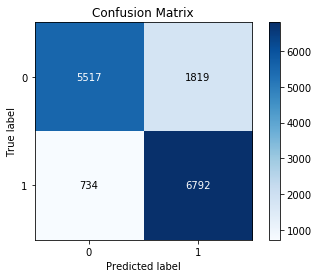

In [55]:
scikitplot.metrics.plot_confusion_matrix(y_test,y_pred)

###### Compute precision, recall, F-measure and support

In [56]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.88      0.75      0.81      7336
          1       0.79      0.90      0.84      7526

avg / total       0.84      0.83      0.83     14862



#### ROC Curve

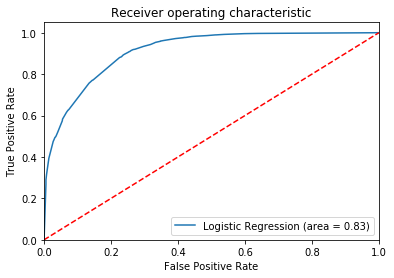

In [57]:
logit_roc_auc = roc_auc_score(y_test, dtree_model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, dtree_model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

###### Feature Selection Using RFE

In [58]:
from sklearn.feature_selection import RFE
selector =  RFE(estimator=DecisionTreeClassifier(max_depth=15,random_state=0,criterion = 'entropy',max_features=13), step=1)
selector.fit(X2,Y)

RFE(estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=15,
            max_features=13, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best'),
  n_features_to_select=None, step=1, verbose=0)

In [59]:
ranks = selector.ranking_.tolist()
dt_rank = pd.DataFrame({'Feature':X.drop('wage_class_>50K', axis=1).columns,'Rank':ranks})
print(dt_rank.Feature[dt_rank.Rank==1].values)

['age' 'fnlwgt' 'education_num' 'capital_gain' 'capital_loss'
 'hours_per_week' 'workclass_ Federal-gov' 'workclass_ Local-gov'
 'workclass_ Private' 'workclass_ Self-emp-inc'
 'workclass_ Self-emp-not-inc' 'workclass_ State-gov' 'education_ 9th'
 'education_ Assoc-acdm' 'education_ Assoc-voc' 'education_ Bachelors'
 'education_ HS-grad' 'education_ Masters' 'education_ Prof-school'
 'education_ Some-college' 'marital_status_ Married-civ-spouse'
 'marital_status_ Married-spouse-absent' 'marital_status_ Never-married'
 'marital_status_ Separated' 'marital_status_ Widowed'
 'occupation_ Adm-clerical' 'occupation_ Craft-repair'
 'occupation_ Exec-managerial' 'occupation_ Farming-fishing'
 'occupation_ Handlers-cleaners' 'occupation_ Machine-op-inspct'
 'occupation_ Other-service' 'occupation_ Prof-specialty'
 'occupation_ Protective-serv' 'occupation_ Sales'
 'occupation_ Tech-support' 'occupation_ Transport-moving'
 'relationship_ Not-in-family' 'relationship_ Other-relative'
 'relations

### 3. K - Nearest Neighbour

###### Identifiying the K Value

In [60]:
from sklearn.neighbors import KNeighborsClassifier

# Splitting the model in to train and test
X_train,X_test,y_train,y_test=train_test_split(X2,Y,test_size=.2,random_state=0)


knn = KNeighborsClassifier(n_neighbors = 20, weights='uniform', algorithm='auto')
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
y_pred_proba = knn.predict_proba(X_test)
# generate evaluation metrics
print("accuracy of KNN Classifier :",metrics.accuracy_score(y_test, y_pred))

accuracy of KNN Classifier : 0.6733279504777284


##### Confusion Matrix

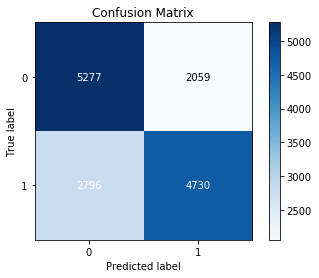

In [61]:
scikitplot.metrics.plot_confusion_matrix(y_test,y_pred)

##### ROC

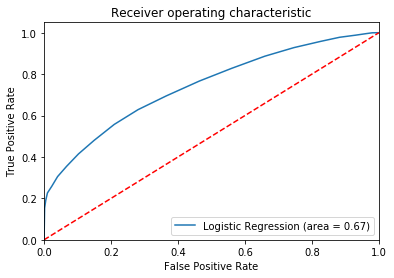

In [62]:
logit_roc_auc = roc_auc_score(y_test, knn.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, knn.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

##### 10 Fold Validation

In [63]:
from sklearn.cross_validation import cross_val_score

scores = cross_val_score(estimator= KNeighborsClassifier(n_neighbors = 20, weights='uniform', algorithm='auto'),     # Model to test
                X= X2,  
                y = Y,      # Target variable
                scoring = "accuracy",               # Scoring metric    
                cv=10)                              # Cross validation folds

print("Accuracy per fold: ")
print("Cross Validation score: ", scores)
print("Average accuracy: ", scores.mean())


Accuracy per fold: 
Cross Validation score:  [0.68057051 0.67451561 0.6866254  0.68124327 0.67949408 0.6781965
 0.67133244 0.68236878 0.67092867 0.68734859]
Average accuracy:  0.6792623836105046


#### Bagging with KNN

Predictions :  [0 0 0 ... 1 1 0]
Prediction Probabilities :  [[0.68  0.32 ]
 [0.705 0.295]
 [0.85  0.15 ]
 ...
 [0.16  0.84 ]
 [0.495 0.505]
 [0.605 0.395]]
Accuracy Score of Bagging for single KNN Model : 0.6783743776073207


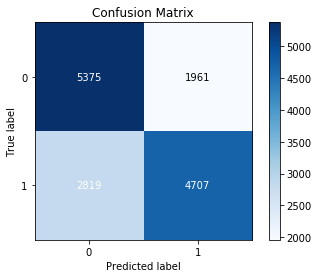

In [64]:
from sklearn.ensemble import BaggingClassifier
bag_KNN = BaggingClassifier(KNeighborsClassifier(n_neighbors = 20, weights='uniform', algorithm='auto'),
                            n_estimators=10, max_samples=0.5,
                            bootstrap=True, random_state=3) 

bag_KNN.fit(X2,Y)

# Splitting the model in to train and test
X_train,X_test,y_train,y_test=train_test_split(X2,Y,test_size=.2,random_state=0)

#### Predictions by the Bagging Ensemble model

bag_preds = bag_KNN.predict(X_test)
print("Predictions : ",bag_preds)

bag_preds_proba = bag_KNN.predict_proba(X_test)
print("Prediction Probabilities : ",bag_preds_proba)

#### Score of the bagging ensemble model

bag_KNN.score(X_test,y_test)

print("Accuracy Score of Bagging for single KNN Model :",metrics.accuracy_score(y_test,bag_preds))

#### Confusion Matrix

scikitplot.metrics.plot_confusion_matrix(y_test,bag_preds)



##### ROC

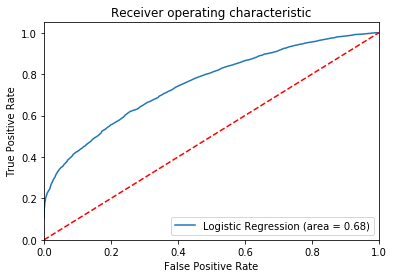

In [65]:
logit_roc_auc = roc_auc_score(y_test, bag_KNN.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, bag_KNN.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

### 4. Random Forest Classifier

In [66]:
# Splitting the model in to train and test
X_train,X_test,y_train,y_test=train_test_split(X2,Y,test_size=.2,random_state=0)

from sklearn.ensemble import  RandomForestClassifier
RF = RandomForestClassifier()
RF.fit(X2,Y)
y_pred = RF.predict(X_test)

print("accuracy of Random Forest Classifier :",metrics.accuracy_score(y_test, y_pred))

accuracy of Random Forest Classifier : 0.9980487148432243


##### Confusion Matrix

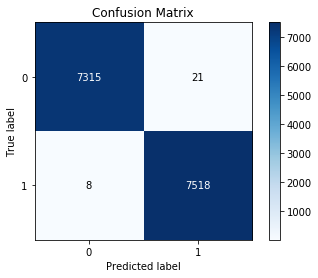

In [67]:
scikitplot.metrics.plot_confusion_matrix(y_test,y_pred)

##### ROC

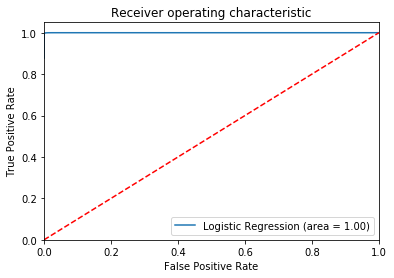

In [68]:
logit_roc_auc = roc_auc_score(y_test, RF.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, RF.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

#### Feature Selection Using RFE

In [69]:
from sklearn.feature_selection import RFE
selector =  RFE(estimator=RandomForestClassifier(), step=1)
selector.fit(X2,Y)

RFE(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
  n_features_to_select=None, step=1, verbose=0)

In [70]:
ranks = selector.ranking_.tolist()
dt_rank = pd.DataFrame({'Feature':X.drop('wage_class_>50K', axis=1).columns,'Rank':ranks})
print(dt_rank.Feature[dt_rank.Rank==1].values)

['age' 'fnlwgt' 'education_num' 'capital_gain' 'capital_loss'
 'hours_per_week' 'workclass_ Federal-gov' 'workclass_ Local-gov'
 'workclass_ Private' 'workclass_ Self-emp-inc'
 'workclass_ Self-emp-not-inc' 'workclass_ State-gov' 'education_ 11th'
 'education_ 7th-8th' 'education_ Assoc-acdm' 'education_ Assoc-voc'
 'education_ Bachelors' 'education_ Doctorate' 'education_ HS-grad'
 'education_ Masters' 'education_ Prof-school' 'education_ Some-college'
 'marital_status_ Married-civ-spouse'
 'marital_status_ Married-spouse-absent' 'marital_status_ Never-married'
 'marital_status_ Separated' 'marital_status_ Widowed'
 'occupation_ Adm-clerical' 'occupation_ Craft-repair'
 'occupation_ Exec-managerial' 'occupation_ Farming-fishing'
 'occupation_ Handlers-cleaners' 'occupation_ Machine-op-inspct'
 'occupation_ Other-service' 'occupation_ Prof-specialty'
 'occupation_ Protective-serv' 'occupation_ Sales'
 'occupation_ Tech-support' 'occupation_ Transport-moving'
 'relationship_ Not-in-fami

#### 10 Fold Cross Validation

In [71]:
from sklearn.cross_validation import cross_val_score

scores = cross_val_score(estimator= RandomForestClassifier(),     # Model to test
                X= X2,  
                y = Y,      # Target variable
                scoring = "accuracy",               # Scoring metric    
                cv=10)                              # Cross validation folds

print("Accuracy per fold: ")
print("Cross Validation score: ", scores)
print("Average accuracy: ", scores.mean())

Accuracy per fold: 
Cross Validation score:  [0.93810549 0.94214209 0.93622174 0.93554898 0.93824004 0.93943472
 0.93297443 0.94347241 0.93701211 0.93930013]
Average accuracy:  0.938245215118646


### 5. XGBClassifier model

In [72]:
# Splitting the model in to train and test
X_train,X_test,y_train,y_test=train_test_split(X2,Y,test_size=.2,random_state=0)

from xgboost import XGBClassifier
classifier=XGBClassifier(max_depth=10)
classifier.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [73]:
y_pred=classifier.predict(X_test)

##### Confusion Matrix

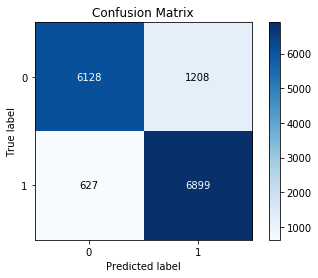

In [74]:
scikitplot.metrics.plot_confusion_matrix(y_test,y_pred)

##### ROC

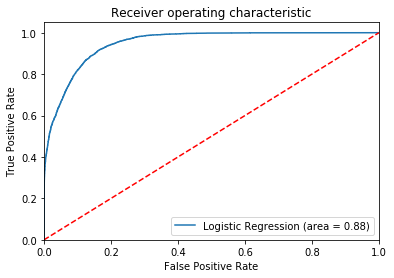

In [75]:
logit_roc_auc = roc_auc_score(y_test, classifier.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, classifier.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

##### 10 Fold Cross Validation

In [76]:
from sklearn.cross_validation import cross_val_score

scores = cross_val_score(estimator= XGBClassifier(max_depth=10),     # Model to test
                X= X2,  
                y = Y,      # Target variable
                scoring = "accuracy",               # Scoring metric    
                cv=10)                              # Cross validation folds

print("Accuracy per fold: ")
print("Cross Validation score: ", scores)
print("Average accuracy: ", scores.mean())

Accuracy per fold: 
Cross Validation score:  [0.87944026 0.87715285 0.87513455 0.87594187 0.87984392 0.87792732
 0.86931359 0.88021534 0.87671602 0.87537012]
Average accuracy:  0.8767055851021446


### Conclusion

* After training the dataset in multiple models, Below are the Accuracy which was obtained.
* Maximum Accuracy Random Forest Classifier 
* Minimum Accuracy K- Nearest Neighbour 


_________________________________________________________________________________
    - Random Forest Classifier - Average accuracy:  0.9381376014673007
    - XGBoost - Average accuracy:  0.8767055851021446
    - Decision Tree Classifier - Average accuracy:  0.8296865288802415
    - Logistic Regression - Average accuracy:  0.8038085859119996
    - K - Nearest Neighbour - Average accuracy:  0.6792623836105046